<a href="https://colab.research.google.com/github/shobhittya/deeplearning/blob/main/ConvNext_Mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [4]:
#import necessary libraries

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt2
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras import regularizers
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


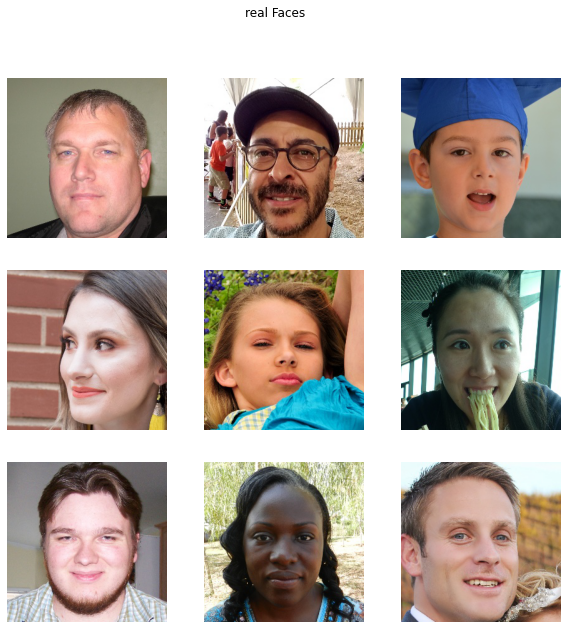

In [6]:
path = '/content/gdrive/MyDrive/dataset'

def plot_img(path, set_):
    dir_ = os.path.join(path, 'train', set_)
    k = 0
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle(set_ + 'Faces')
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))          
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
  #  fig.tight_layout()
    plt.suptitle(set_ + ' Faces')
    return plt

plot_img(path, 'real').show()

In [7]:
bs = 32
row, col = 224, 224
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True
                                  )
training_set = train_datagen.flow_from_directory(path + '/train',
                                                 class_mode='binary',
                                                 shuffle=True,
                                                 target_size=(row,col),
                                                 batch_size=bs
                                                )
val_test_datagen = ImageDataGenerator(rescale=1./255)

validation_set = val_test_datagen.flow_from_directory(path + '/valid',
                                                      class_mode='binary',
                                                      shuffle=True,
                                                      target_size=(row,col),
                                                      batch_size=bs
                                                     ) 
test_set = val_test_datagen.flow_from_directory(path + '/test',
                                                class_mode='binary',
                                                shuffle=True,
                                                target_size=(row,col),
                                                batch_size=bs
                                               )
training_set.class_indices


Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


{'fake': 0, 'real': 1}

**LR Function**

In [8]:
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

**Model**

In [9]:
# Model
IMAGE_SIZE = [224, 224]
MODEL_PATH = "https://tfhub.dev/sayakpaul/convnext_tiny_1k_224_fe/1"

# # TPU
# if tpu:
#     BATCH_SIZE = (
#         16 * strategy.num_replicas_in_sync
#     )  # a TPU has 8 cores so this will be 128
# else:
#     BATCH_SIZE = 32  # on Colab/GPU, a higher batch size may throw(OOM)

# Dataset
CLASSES = [
    "fake",
    "real",
]  # don't change the order

# Other constants
MEAN = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])  # imagenet mean
STD = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])  # imagenet std
AUTO = tf.data.AUTOTUNE

In [10]:
def get_model(model_path=MODEL_PATH, res=224, num_classes=2):
    hub_layer = hub.KerasLayer(model_path, trainable=True)

    model = keras.Sequential(
        [
            keras.layers.InputLayer((res, res, 3)),
            hub_layer,
            keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
import keras
import keras.utils
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam

In [12]:
get_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 768)               27820128  
                                                                 
 dense (Dense)               (None, 2)                 1538      
                                                                 
Total params: 27,821,666
Trainable params: 27,821,666
Non-trainable params: 0
_________________________________________________________________


**Hyperparameters**

In [13]:
EPOCHS = 100
WARMUP_STEPS = 15
INIT_LR = 0.03
WAMRUP_LR = 0.006
BATCH_SIZE = 64


TOTAL_STEPS = int((2000 / BATCH_SIZE) * EPOCHS)
# TOTAL_STEPS = 100

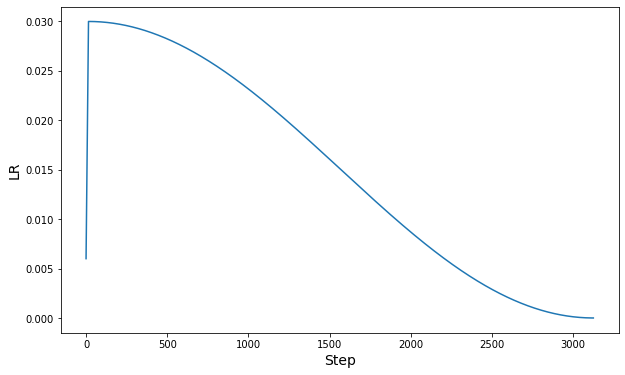

In [14]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.figure(figsize=(10, 6))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [15]:
checkpoint = ModelCheckpoint(filepath='/content/Model_weights/CNet.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=4, 
                              verbose=1
                             )
csv_logger = CSVLogger('training.log')

early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0.001,
                              patience =5,
                              verbose = 0,
                              mode = 'auto')

callbacks = [checkpoint, early_stopping, csv_logger]

In [16]:
import os
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [17]:
optimizer = tf.keras.optimizers.SGD(scheduled_lrs)
loss = keras.losses.SparseCategoricalCrossentropy()
# loss=tf.keras.losses.BinaryCrossentropy()

**Training**

In [18]:
# with strategy.scope(): # this line is all that is needed to run on TPU (or multi-GPU, ...)
model = get_model(MODEL_PATH)
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

In [23]:
history = model.fit(training_set, validation_data=validation_set, epochs=10)

Epoch 1/10
94/94 [==============================] - 167s 2s/step - loss: 0.3540 - accuracy: 0.8483 - val_loss: 0.4450 - val_accuracy: 0.7940
Epoch 2/10
94/94 [==============================] - 166s 2s/step - loss: 0.3169 - accuracy: 0.8683 - val_loss: 0.3912 - val_accuracy: 0.8300
Epoch 3/10
94/94 [==============================] - 166s 2s/step - loss: 0.2594 - accuracy: 0.8960 - val_loss: 0.4038 - val_accuracy: 0.8170
Epoch 4/10
94/94 [==============================] - 166s 2s/step - loss: 0.2301 - accuracy: 0.9040 - val_loss: 0.5400 - val_accuracy: 0.7730
Epoch 5/10
94/94 [==============================] - 166s 2s/step - loss: 0.1583 - accuracy: 0.9440 - val_loss: 0.3838 - val_accuracy: 0.8450
Epoch 6/10
94/94 [==============================] - 166s 2s/step - loss: 0.1123 - accuracy: 0.9630 - val_loss: 0.3793 - val_accuracy: 0.8610
Epoch 7/10
94/94 [==============================] - 166s 2s/step - loss: 0.0903 - accuracy: 0.9713 - val_loss: 0.3535 - val_accuracy: 0.8600
Epoch 8/10
94

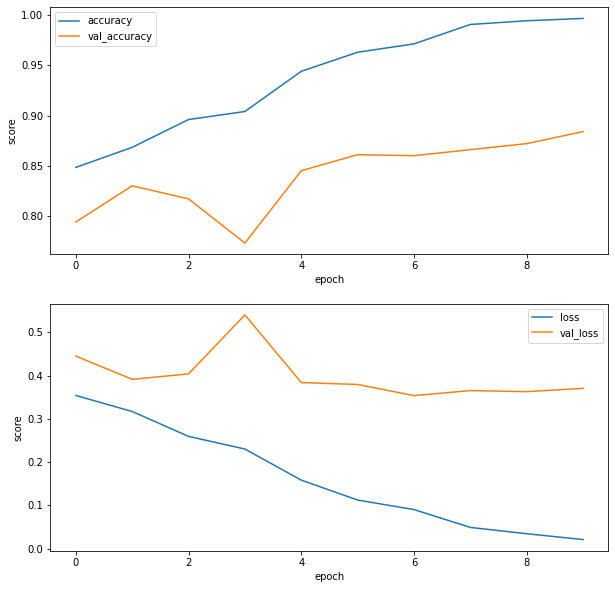

In [24]:
result = pd.DataFrame(history.history)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
result[["accuracy", "val_accuracy"]].plot(xlabel="epoch", ylabel="score", ax=ax[0])
result[["loss", "val_loss"]].plot(xlabel="epoch", ylabel="score", ax=ax[1])

**Predictions**

In [25]:
sample_images, sample_labels = next(iter(test_set))

predictions = model.predict(sample_images, batch_size=16).argmax(axis=-1)
evaluations = model.evaluate(sample_images, sample_labels, batch_size=16)

print("[test_loss, test_acc]", evaluations)

2/2 [==============================] - 1s 256ms/step - loss: 0.2728 - accuracy: 0.8750
[test_loss, test_acc] [0.27278947830200195, 0.875]


**Saving Model Weights**

In [22]:
model.save('Cnet.h5')

NotImplementedError: ignored

**Resume Training**